In [1]:
import os
import cv2
import numpy as np
import kagglehub
import keras
import pandas as pd
import tensorflow.data as tfd
import tensorflow.image as tfi

import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, DenseNet121
from IPython.display import clear_output as cls
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Data Processing

In [2]:
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)
path = '/kaggle/input/ai-vs-human-generated-dataset/'

Using Colab cache for faster access to the 'ai-vs-human-generated-dataset' dataset.
Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [3]:
train_csv = pd.read_csv(path + "train.csv")
train_csv["file_name"] = path + train_csv["file_name"]

test_csv = pd.read_csv(path + "test.csv")
test_csv["file_path"] = path + test_csv["id"]

print(f"Number of training samples: {train_csv.shape[0]}")
print(f"Number of testing samples : {test_csv.shape[0]}")

Number of training samples: 79950
Number of testing samples : 5540


In [4]:
train_csv = train_csv.drop(columns='Unnamed: 0', axis=1)
train_csv.head()

,file_name,label
0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1


In [5]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  79950 non-null  object
 1   label      79950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [6]:
test_csv.head()

,id,file_path
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...


In [7]:
# ----------------- Check for Missing Files -----------------
# missing_files_train = train_csv[~train_csv["file_name"].apply(os.path.exists)]
# missing_files_test = test_csv[~test_csv["file_path"].apply(os.path.exists)]
# print(f"Missing train images: {len(missing_files_train)}")
# print(f"Missing test images: {len(missing_files_test)}")

In [8]:
# ----------------- Compute Class Distribution -----------------
class_distribution = train_csv['label'].value_counts()
class_distribution

,count
label,
1,39975
0,39975


In [9]:
# ----------------- Display Image Shapes -----------------
for i in range(5):
    image_path = os.path.join(path, train_csv.file_name[i])

    try:
        image = plt.imread(image_path)
        shape = image.shape

        print(f"Image {i+1}: {train_csv.file_name[i]}")
        print(f" - Shape: {shape}")
        print(f" - Image Path: {image_path}\n")

    except FileNotFoundError:
        print(f"⚠ Warning: File not found - {image_path}")

    except Exception as e:
        print(f"⚠ Error loading image {train_csv.file_name[i]}: {e}")

Image 1: /kaggle/input/ai-vs-human-generated-dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg
 - Shape: (768, 512, 3)
 - Image Path: /kaggle/input/ai-vs-human-generated-dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg

Image 2: /kaggle/input/ai-vs-human-generated-dataset/train_data/041be3153810433ab146bc97d5af505c.jpg
 - Shape: (768, 512, 3)
 - Image Path: /kaggle/input/ai-vs-human-generated-dataset/train_data/041be3153810433ab146bc97d5af505c.jpg

Image 3: /kaggle/input/ai-vs-human-generated-dataset/train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg
 - Shape: (512, 768, 3)
 - Image Path: /kaggle/input/ai-vs-human-generated-dataset/train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg

Image 4: /kaggle/input/ai-vs-human-generated-dataset/train_data/8542fe161d9147be8e835e50c0de39cd.jpg
 - Shape: (512, 768, 3)
 - Image Path: /kaggle/input/ai-vs-human-generated-dataset/train_data/8542fe161d9147be8e835e50c0de39cd.jpg

Image 5: /kaggle/input/ai-vs-human-generated-dataset/train_data/5d81

In [10]:
# ----------------- Convert Label Column to String -----------------
train_csv["label"] = train_csv["label"].astype(str)

# ----------------- Display First Few Rows -----------------
train_csv.head()

,file_name,label
0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1


In [11]:
def preprocess_and_darken(image):
    """
    Mengubah skala gambar ke rentang [0, 1] dan menggelapkannya sebesar 50%.
    """
    image = image.astype('float32')
    image /= 255.0
    darkening_factor = 0.6
    darkened_image = image * darkening_factor
    return darkened_image

# ----------------- Initialize Data Generator -----------------
data_generator = ImageDataGenerator(validation_split=0.3, preprocessing_function=preprocess_and_darken)

In [13]:
# ----------------- Create Training Data Generator -----------------
train_generator = data_generator.flow_from_dataframe(
    train_csv,
    x_col="file_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

# ----------------- Create Validation Data Generator -----------------
valid_generator = data_generator.flow_from_dataframe(
    train_csv,
    x_col="file_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

Found 55965 validated image filenames belonging to 2 classes.
Found 23985 validated image filenames belonging to 2 classes.


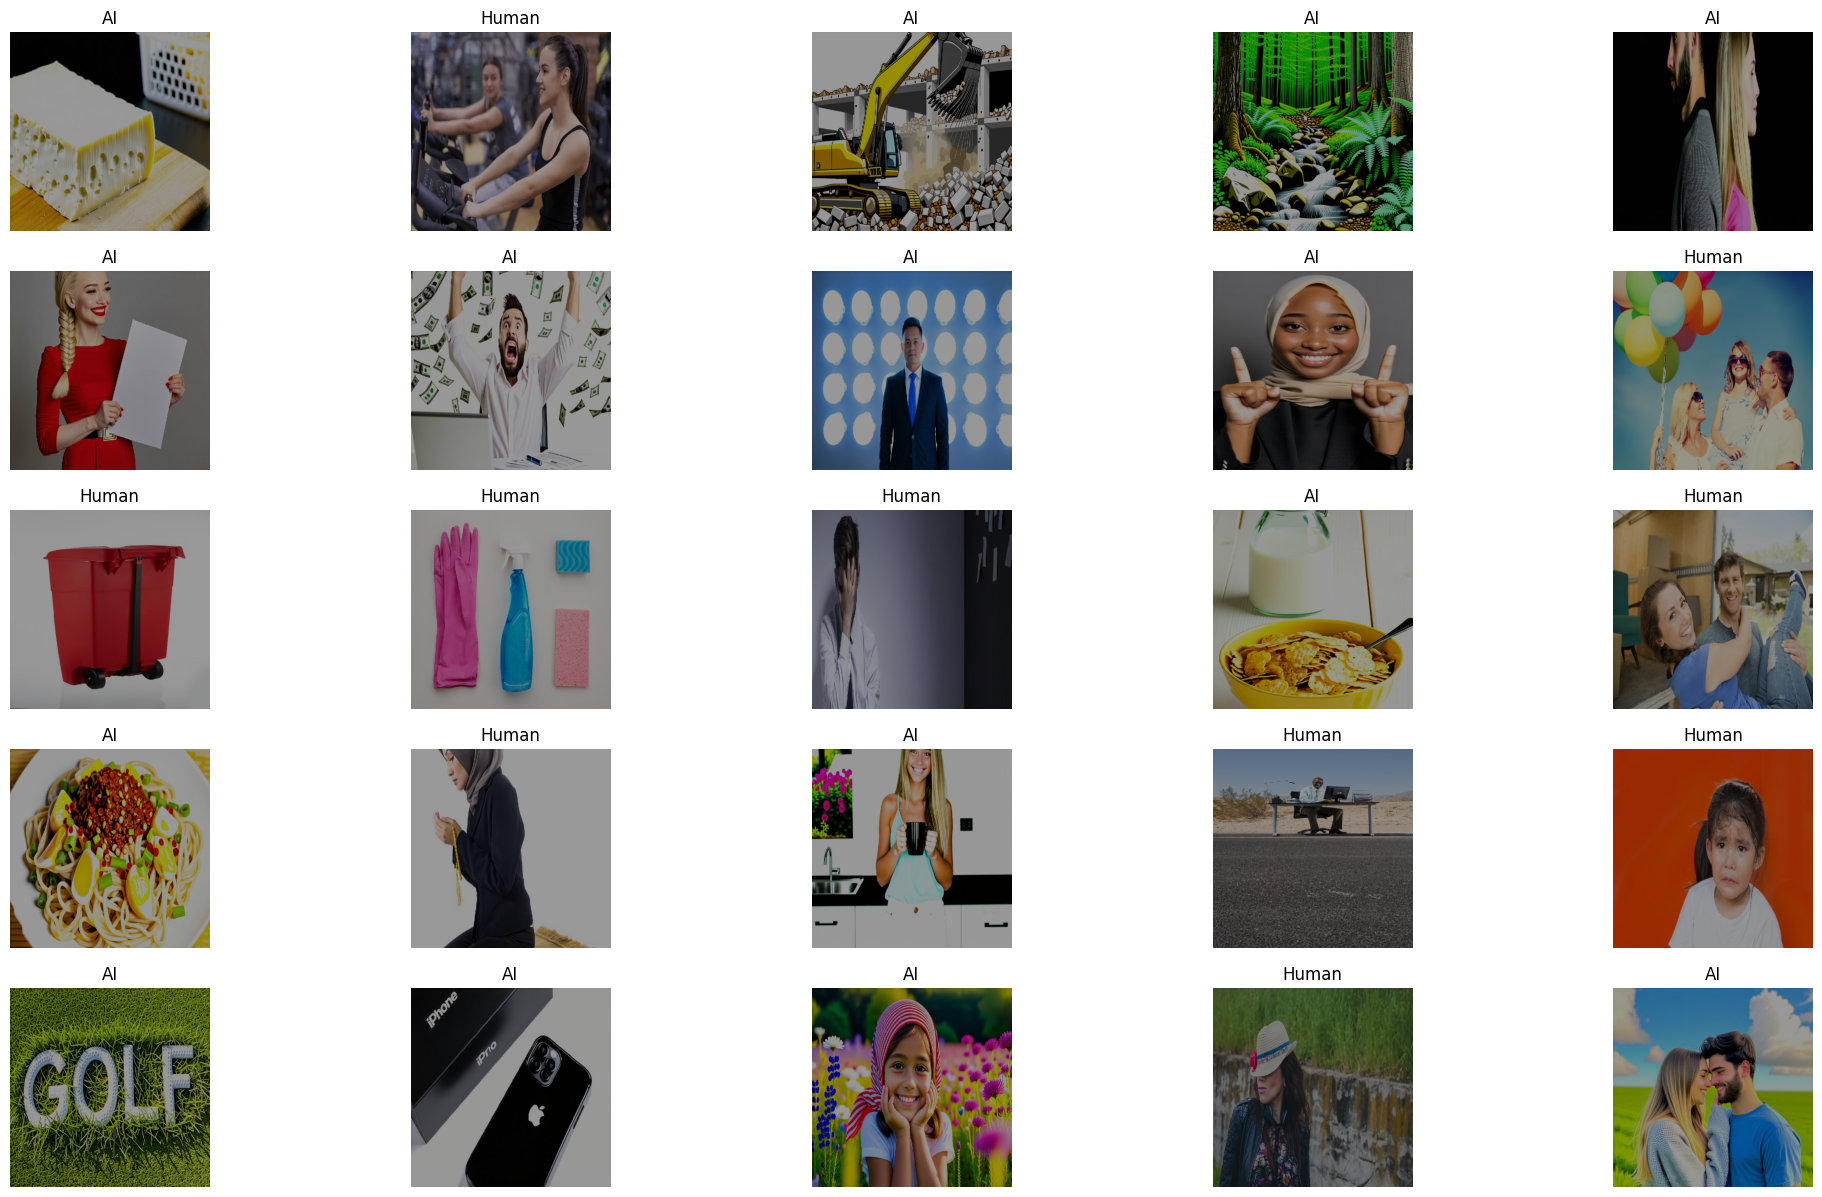

In [14]:
def show_images(data, n_rows=5, n_cols=5, figsize=(25, 15)):
    """
    Displays a grid of images from a given dataset.

    Args:
        data (tf.data.Dataset): The dataset containing images and labels.
        n_rows (int): Number of rows in the grid.
        n_cols (int): Number of columns in the grid.
        figsize (tuple): Figure size for the plot.

    Returns:
        None
    """
    images, labels = next(iter(data))

    plt.figure(figsize=figsize)

    n_image = 0

    for i in range(n_rows):
        for j in range(n_cols):
            if n_image < len(images):
                plt.subplot(n_rows, n_cols, n_image + 1)
                plt.imshow(images[n_image])
                plt.axis('off')
                plt.title("AI" if labels[n_image] == 1.0 else "Human")
                n_image += 1

    plt.show()

show_images(valid_generator)

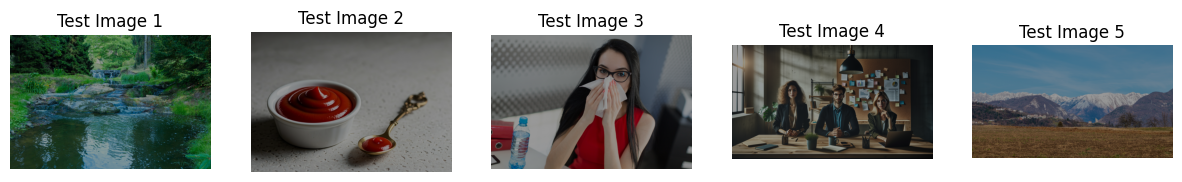

In [15]:
# ----------------- Function to Display Test Images -----------------
def show_test_images(df, num_images=5):
    sample_images = df.sample(num_images, random_state=42)["file_path"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # --- TAMBAHKAN LANGKAH UNTUK MENGGELAPKAN GAMBAR DI SINI ---
        darkening_factor = 0.6
        # Menggunakan cv2.convertScaleAbs untuk mengubah brightness
        # alpha < 1 untuk menggelapkan, beta adalah penambah brightness (kita set 0)

        img_darkened = cv2.convertScaleAbs(img, alpha=darkening_factor, beta=0)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img_darkened)
        plt.axis("off")
        plt.title(f"Test Image {i+1}")

    plt.show()

# ----------------- Show Test Images -----------------
show_test_images(test_csv)

# ResNet50V2 Model

In [ ]:
resnet50v2_path = '/kaggle/input/ai-vs-human/tensorflow2/default/1/ResNet50V2-AIvsHumanGenImages.keras'

if os.path.exists(resnet50v2_path):
    resnet50_model = keras.models.load_model(resnet50v2_path, compile=True)
    resnet50_model.trainable = False
else:
    resnet50_base_model = ResNet50V2(
        input_shape=(512, 512, 3),
        include_top=False,
        weights='imagenet'
    )
    resnet50_base_model.trainable = False

    inputs = keras.Input(shape=(512, 512, 3))
    x = resnet50_base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    resnet50_model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='ResNet50V2-AIvsHumanGenImages'
    )

    resnet50_model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )

# ----------------- Model summary -----------------
resnet50_model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ResNet50V2-AIvsHumanGenImages"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 16, 16, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,630,401 (90.14 MB)

 Trainable params: 65,601 (256.25 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
resnet50v2_history_path = '/kaggle/input/ai-vs-human/tensorflow2/default/1/ResNet50V2-AIvsHumanGenImages-Logs.csv'

if os.path.exists(resnet50v2_history_path):
    resnet50v2_history = pd.read_csv(resnet50v2_history_path)  # Load training logs
else:
    steps_per_epoch = len(train_generator)
    validation_steps = len(valid_generator)
    resnet50_model_history = resnet50_model.fit(
        train_generator,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
            keras.callbacks.ModelCheckpoint('ResNet50V2-AIvsHumanGenImages.keras', save_best_only=True),
            keras.callbacks.CSVLogger('ResNet50V2-AIvsHumanGenImages-Logs.csv', append=True),
            keras.callbacks.TerminateOnNaN()
        ]
    )
    resnet50v2_history = pd.DataFrame(resnet50_model_history.history)
    resnet50v2_history.to_csv('ResNet50V2-AIvsHumanGenImages-Logs.csv', index=False)

resnet50v2_history.head()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 1375s 769ms/step - accuracy: 0.8991 - loss: 0.2429 - precision: 0.8944 - recall: 0.9020 - val_accuracy: 0.9561 - val_loss: 0.1119 - val_precision: 0.9535 - val_recall: 0.9590
Epoch 2/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 953s 545ms/step - accuracy: 0.9532 - loss: 0.1208 - precision: 0.9530 - recall: 0.9538 - val_accuracy: 0.9597 - val_loss: 0.1011 - val_precision: 0.9616 - val_recall: 0.9577
Epoch 3/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 959s 548ms/step - accuracy: 0.9589 - loss: 0.1049 - precision: 0.9592 - recall: 0.9580 - val_accuracy: 0.9618 - val_loss: 0.0968 - val_precision: 0.9664 - val_recall: 0.9568
Epoch 4/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 972s 543ms/step - accuracy: 0.9629 - loss: 0.0965 - precision: 0.9638 - recall: 0.9616 - val_accuracy: 0.9650 - val_loss: 0.0938 - val_precision: 0.9716 - val_recall: 0.9580
Epoch 5/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 1026s 568ms/step - accuracy: 0.9647 - loss: 0.0866 - precision: 0.9656 - recall: 0.9635 - val

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.928330,0.179471,0.926849,0.930062,0.956098,0.111882,0.953490,0.958976
1,0.953292,0.120056,0.953421,0.953148,0.959725,0.101055,0.961574,0.957725
2,0.958617,0.105787,0.958682,0.958545,0.961768,0.096750,0.966397,0.956808
3,0.962387,0.097351,0.963729,0.960939,0.964978,0.093829,0.971586,0.957976
4,0.965032,0.087551,0.965980,0.964013,0.965228,0.092879,0.973682,0.956308


In [ ]:
train_loss, train_accuracy, *_ = resnet50_model.evaluate(train_generator)  # Ignore extra metrics
print(f"Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1749/1749 ━━━━━━━━━━━━━━━━━━━━ 672s 384ms/step - accuracy: 0.9861 - loss: 0.0389 - precision: 0.9870 - recall: 0.9852
Accuracy on train data: 98.70% | Loss: 0.0373


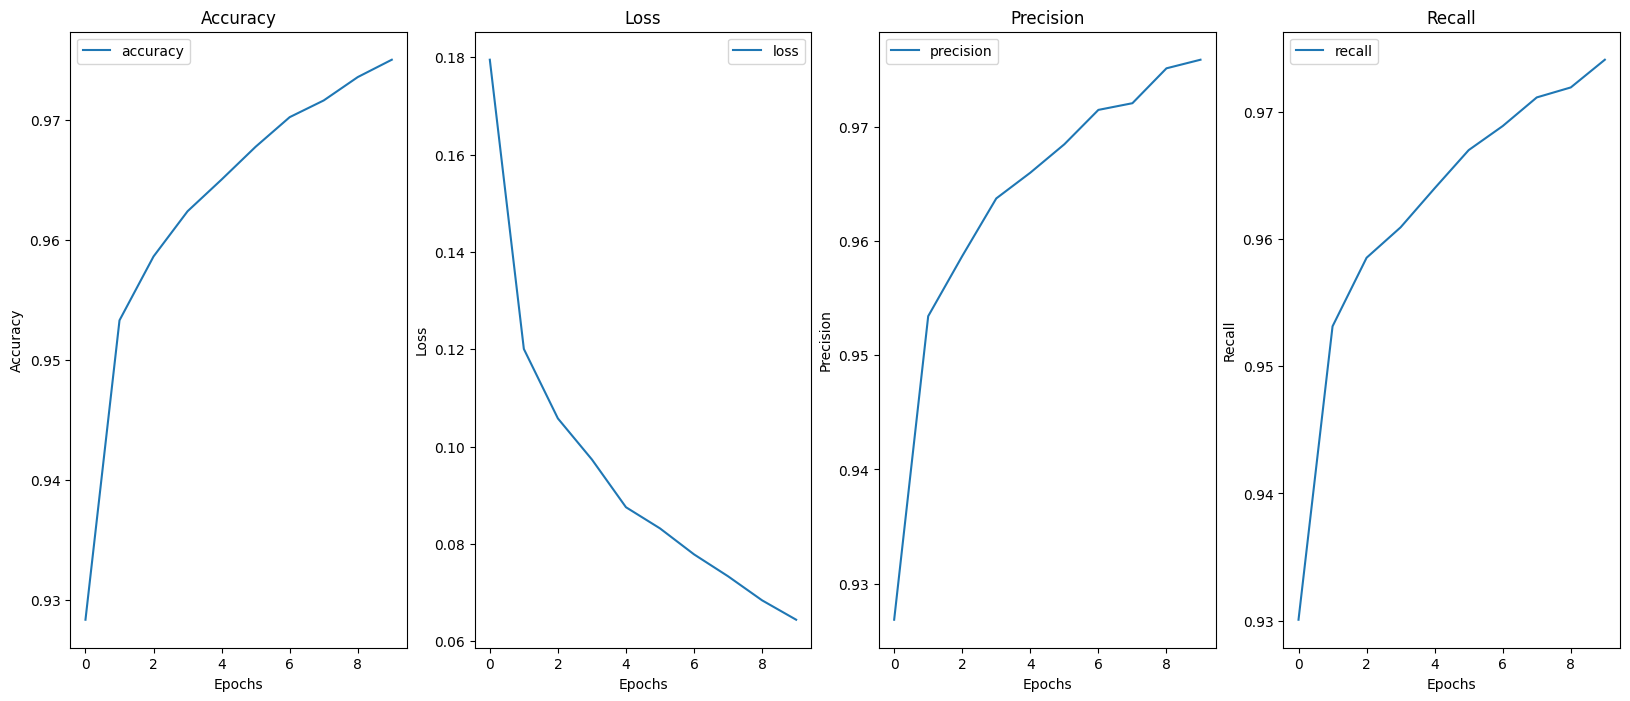

In [ ]:
acc = resnet50_model_history.history['accuracy']
loss = resnet50_model_history.history['loss']
prec = resnet50_model_history.history['precision']
rec = resnet50_model_history.history['recall']

plt.figure(figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.plot(acc, label='accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(loss, label='loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(prec, label='precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(rec, label='recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [ ]:
print("Manually saving the final model state...")
resnet50_model.save('ResNet50V2-AIvsHumanGenImages-Final.keras')
print("Model saved.")

Manually saving the final model state...
Model saved.


# MobileNetV2 Model

In [ ]:
mobilenetv2_path = '/kaggle/input/ai-vs-human/tensorflow2/default/1/MobileNetV2-AIvsHumanGenImages.keras'

if os.path.exists(mobilenetv2_path):
    mobilenet_model  = keras.models.load_model(mobilenetv2_path, compile=True)
    mobilenet_model.trainable = False
else:
    mobilenet_base_model = MobileNetV2(
        input_shape=(512, 512, 3),
        include_top=False,
        weights='imagenet'
    )

    mobilenet_base_model.trainable = False

    inputs = keras.Input(shape=(512, 512, 3))
    x = mobilenet_base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)


    mobilenet_model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='MobileNetV2-AIvsHumanGenImages'
    )

    mobilenet_model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )

mobilenet_model.summary()

/tmp/ipython-input-1547106937.py:7: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2-AIvsHumanGenImages"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 16, 16, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,009 (8.77 MB)

 Trainable params: 41,025 (160.25 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
mobilenetv2_history_path  = '/kaggle/input/ai-vs-human/tensorflow2/default/1/MobileNetV2-AIvsHumanGenImages-Logs.csv'

if os.path.exists(mobilenetv2_history_path):
    mobilenet_model_history = pd.read_csv(mobilenetv2_history_path)
else:
    steps_per_epoch = len(train_generator)
    validation_steps = len(valid_generator)
    mobilenet_model_history = mobilenet_model.fit(
        train_generator,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
            keras.callbacks.ModelCheckpoint('MobileNetV2-AIvsHumanGenImages.keras', save_best_only=True),
            keras.callbacks.CSVLogger('MobileNetV2-AIvsHumanGenImages-Logs.csv', append=True),
            keras.callbacks.TerminateOnNaN()
        ]
    )
    mobilenetv2_history  = pd.DataFrame(mobilenet_model_history.history)
    mobilenetv2_history.to_csv('MobileNetV2-AIvsHumanGenImages-Logs.csv', index=False)

mobilenetv2_history.head()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 996s 555ms/step - accuracy: 0.8927 - loss: 0.2555 - precision: 0.8913 - recall: 0.8934 - val_accuracy: 0.9449 - val_loss: 0.1369 - val_precision: 0.9655 - val_recall: 0.9228
Epoch 2/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 722s 413ms/step - accuracy: 0.9434 - loss: 0.1424 - precision: 0.9442 - recall: 0.9416 - val_accuracy: 0.9539 - val_loss: 0.1210 - val_precision: 0.9496 - val_recall: 0.9586
Epoch 3/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 716s 409ms/step - accuracy: 0.9503 - loss: 0.1286 - precision: 0.9500 - recall: 0.9503 - val_accuracy: 0.9548 - val_loss: 0.1142 - val_precision: 0.9598 - val_recall: 0.9495
Epoch 4/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 719s 411ms/step - accuracy: 0.9539 - loss: 0.1192 - precision: 0.9535 - recall: 0.9537 - val_accuracy: 0.9571 - val_loss: 0.1103 - val_precision: 0.9610 - val_recall: 0.9528
Epoch 5/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 717s 410ms/step - accuracy: 0.9554 - loss: 0.1136 - precision: 0.9551 - recall: 0.9564 - val_a

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.924203,0.192317,0.923929,0.924523,0.944882,0.136919,0.965454,0.922788
1,0.944162,0.139451,0.945290,0.942892,0.953888,0.120991,0.949616,0.958643
2,0.950630,0.126529,0.950677,0.950575,0.954847,0.114189,0.959794,0.949471
3,0.954132,0.118280,0.953434,0.954900,0.957057,0.110264,0.960979,0.952806
4,0.954722,0.115573,0.954429,0.955043,0.956098,0.113147,0.943633,0.970149


In [ ]:
train_loss, train_accuracy, *_ = mobilenet_model.evaluate(train_generator)  # Ignore extra metrics
print(f"Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1749/1749 ━━━━━━━━━━━━━━━━━━━━ 507s 290ms/step - accuracy: 0.9762 - loss: 0.0724 - precision: 0.9830 - recall: 0.9692
Accuracy on train data: 97.59% | Loss: 0.0722


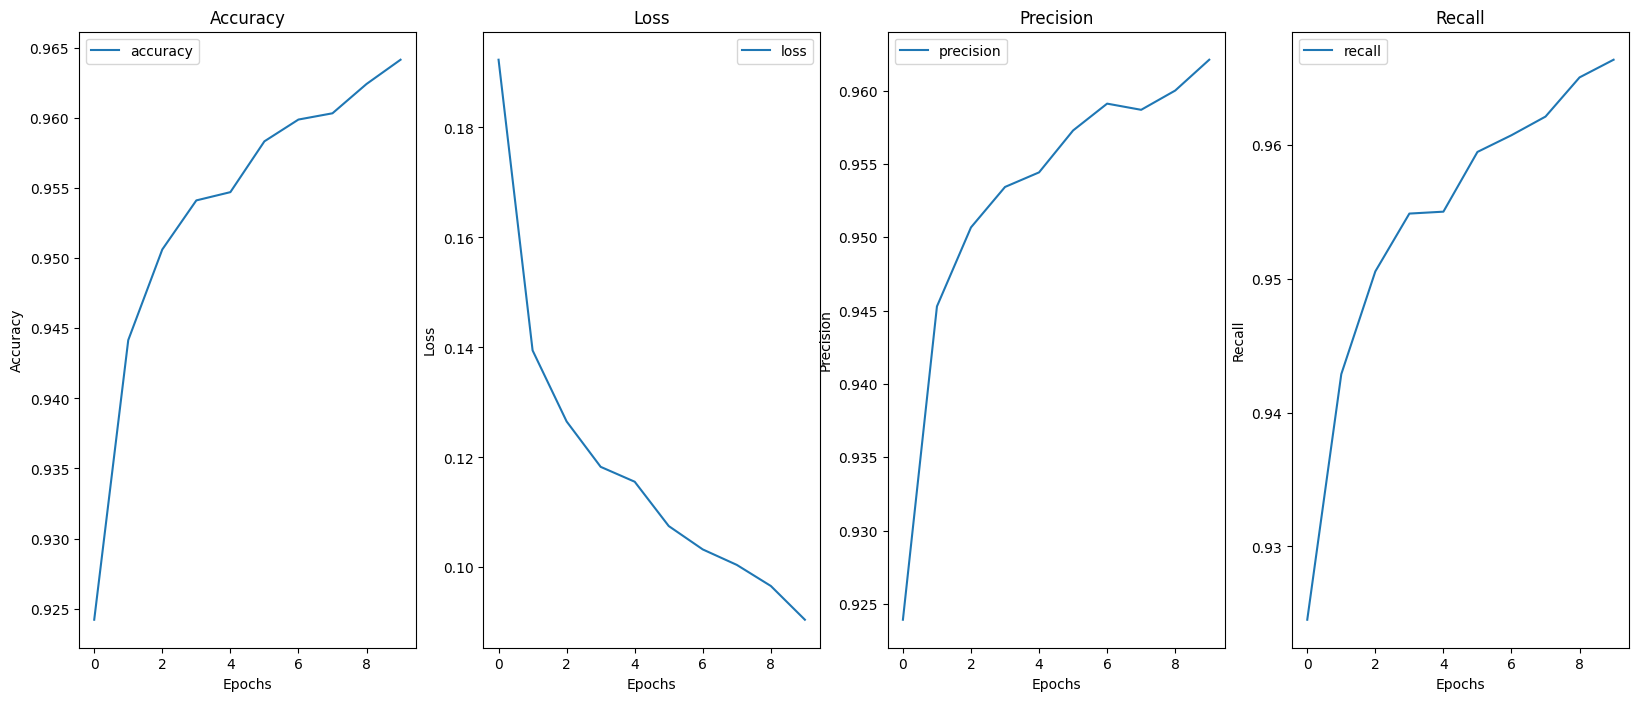

In [ ]:
acc = mobilenet_model_history.history['accuracy']
loss = mobilenet_model_history.history['loss']
prec = mobilenet_model_history.history['precision']
rec = mobilenet_model_history.history['recall']

plt.figure(figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.plot(acc, label='accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(loss, label='loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(prec, label='precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(rec, label='recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [ ]:
print("Manually saving the final model state...")
mobilenet_model.save('MobileNetV2-AIvsHumanGenImages-Final.keras')
print("Model saved.")

Manually saving the final model state...
Model saved.


# DenseNet121 Model

In [16]:
densenet121_path = 'DenseNet121-AIvsHumanGenImages.keras'

if os.path.exists(densenet121_path):
    densenet_model = keras.models.load_model(densenet121_path, compile=True)
    densenet_model.trainable = False
else:
    densenet_base_model = DenseNet121(
        input_shape=(512, 512, 3),
        include_top=False,
        weights='imagenet'
    )
    densenet_base_model.trainable = False

    inputs = keras.Input(shape=(512, 512, 3))
    x = densenet_base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    densenet_model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='DenseNet121-AIvsHumanGenImages'
    )

    densenet_model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )

densenet_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "DenseNet121-AIvsHumanGenImages"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 16, 16, 1024)   │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,070,337 (26.97 MB)

 Trainable params: 32,833 (128.25 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [17]:
densenet121_history_path = 'DenseNet121-AIvsHumanGenImages-Logs.csv'

if os.path.exists(densenet121_history_path):
    densenet121_history = pd.read_csv(densenet121_history_path)
else:
    steps_per_epoch = len(train_generator)
    validation_steps = len(valid_generator)
    densenet_model_history = densenet_model.fit(
        train_generator,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
            keras.callbacks.ModelCheckpoint('DenseNet121-AIvsHumanGenImages.keras', save_best_only=True),
            keras.callbacks.CSVLogger('DenseNet121-AIvsHumanGenImages-Logs.csv', append=True),
            keras.callbacks.TerminateOnNaN()
        ]
    )
    densenet121_history = pd.DataFrame(densenet_model_history.history)
    densenet121_history.to_csv('DenseNet121-AIvsHumanGenImages-Logs.csv', index=False)

densenet121_history.head()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 1347s 744ms/step - accuracy: 0.8602 - loss: 0.3164 - precision: 0.8590 - recall: 0.8621 - val_accuracy: 0.9461 - val_loss: 0.1402 - val_precision: 0.9590 - val_recall: 0.9321
Epoch 2/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 925s 529ms/step - accuracy: 0.9376 - loss: 0.1584 - precision: 0.9382 - recall: 0.9370 - val_accuracy: 0.9510 - val_loss: 0.1299 - val_precision: 0.9581 - val_recall: 0.9433
Epoch 3/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 923s 528ms/step - accuracy: 0.9453 - loss: 0.1411 - precision: 0.9450 - recall: 0.9457 - val_accuracy: 0.9506 - val_loss: 0.1240 - val_precision: 0.9595 - val_recall: 0.9408
Epoch 4/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 926s 529ms/step - accuracy: 0.9495 - loss: 0.1302 - precision: 0.9489 - recall: 0.9508 - val_accuracy: 0.9527 - val_loss: 0.1206 - val_precision: 0.9680 - val_recall: 0.9363
Epoch 5/10
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 978s 527ms/step - accuracy: 0.9506 - loss: 0.1275 - precision: 0.9488 - recall: 0.9529 - val_

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.908836,0.225478,0.907901,0.909978,0.946133,0.140226,0.958995,0.932127
1,0.939730,0.152836,0.939588,0.939890,0.951011,0.129920,0.958079,0.943300
2,0.945198,0.139419,0.944419,0.946072,0.950552,0.123966,0.959520,0.940799
3,0.948361,0.132082,0.947847,0.948931,0.952679,0.120593,0.968017,0.936296
4,0.951094,0.125596,0.949183,0.953220,0.954972,0.116377,0.947217,0.963645


In [18]:
train_loss, train_accuracy, *_ = densenet_model.evaluate(train_generator)
print(f"DenseNet121 - Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1749/1749 ━━━━━━━━━━━━━━━━━━━━ 660s 377ms/step - accuracy: 0.9666 - loss: 0.0880 - precision: 0.9679 - recall: 0.9658
DenseNet121 - Accuracy on train data: 96.57% | Loss: 0.0895


In [ ]:
acc = densenet_model_history.history['accuracy']
loss = densenet_model_history.history['loss']
prec = densenet_model_history.history['precision']
rec = densenet_model_history.history['recall']

plt.figure(figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.plot(acc, label='accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(loss, label='loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(prec, label='precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(rec, label='recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [20]:
print("Manually saving the final model state...")
densenet_model.save("DenseNet121-AIvsHumanGenImages-Final.keras")
print("Model saved.")

Manually saving the final model state...
Model saved.


# Model Comparison

Berhasil memuat log untuk ResNet50V2
Berhasil memuat log untuk MobileNetV2
Berhasil memuat log untuk DenseNet121

Comparison plot has been save as 'model_comparison_plots.png'


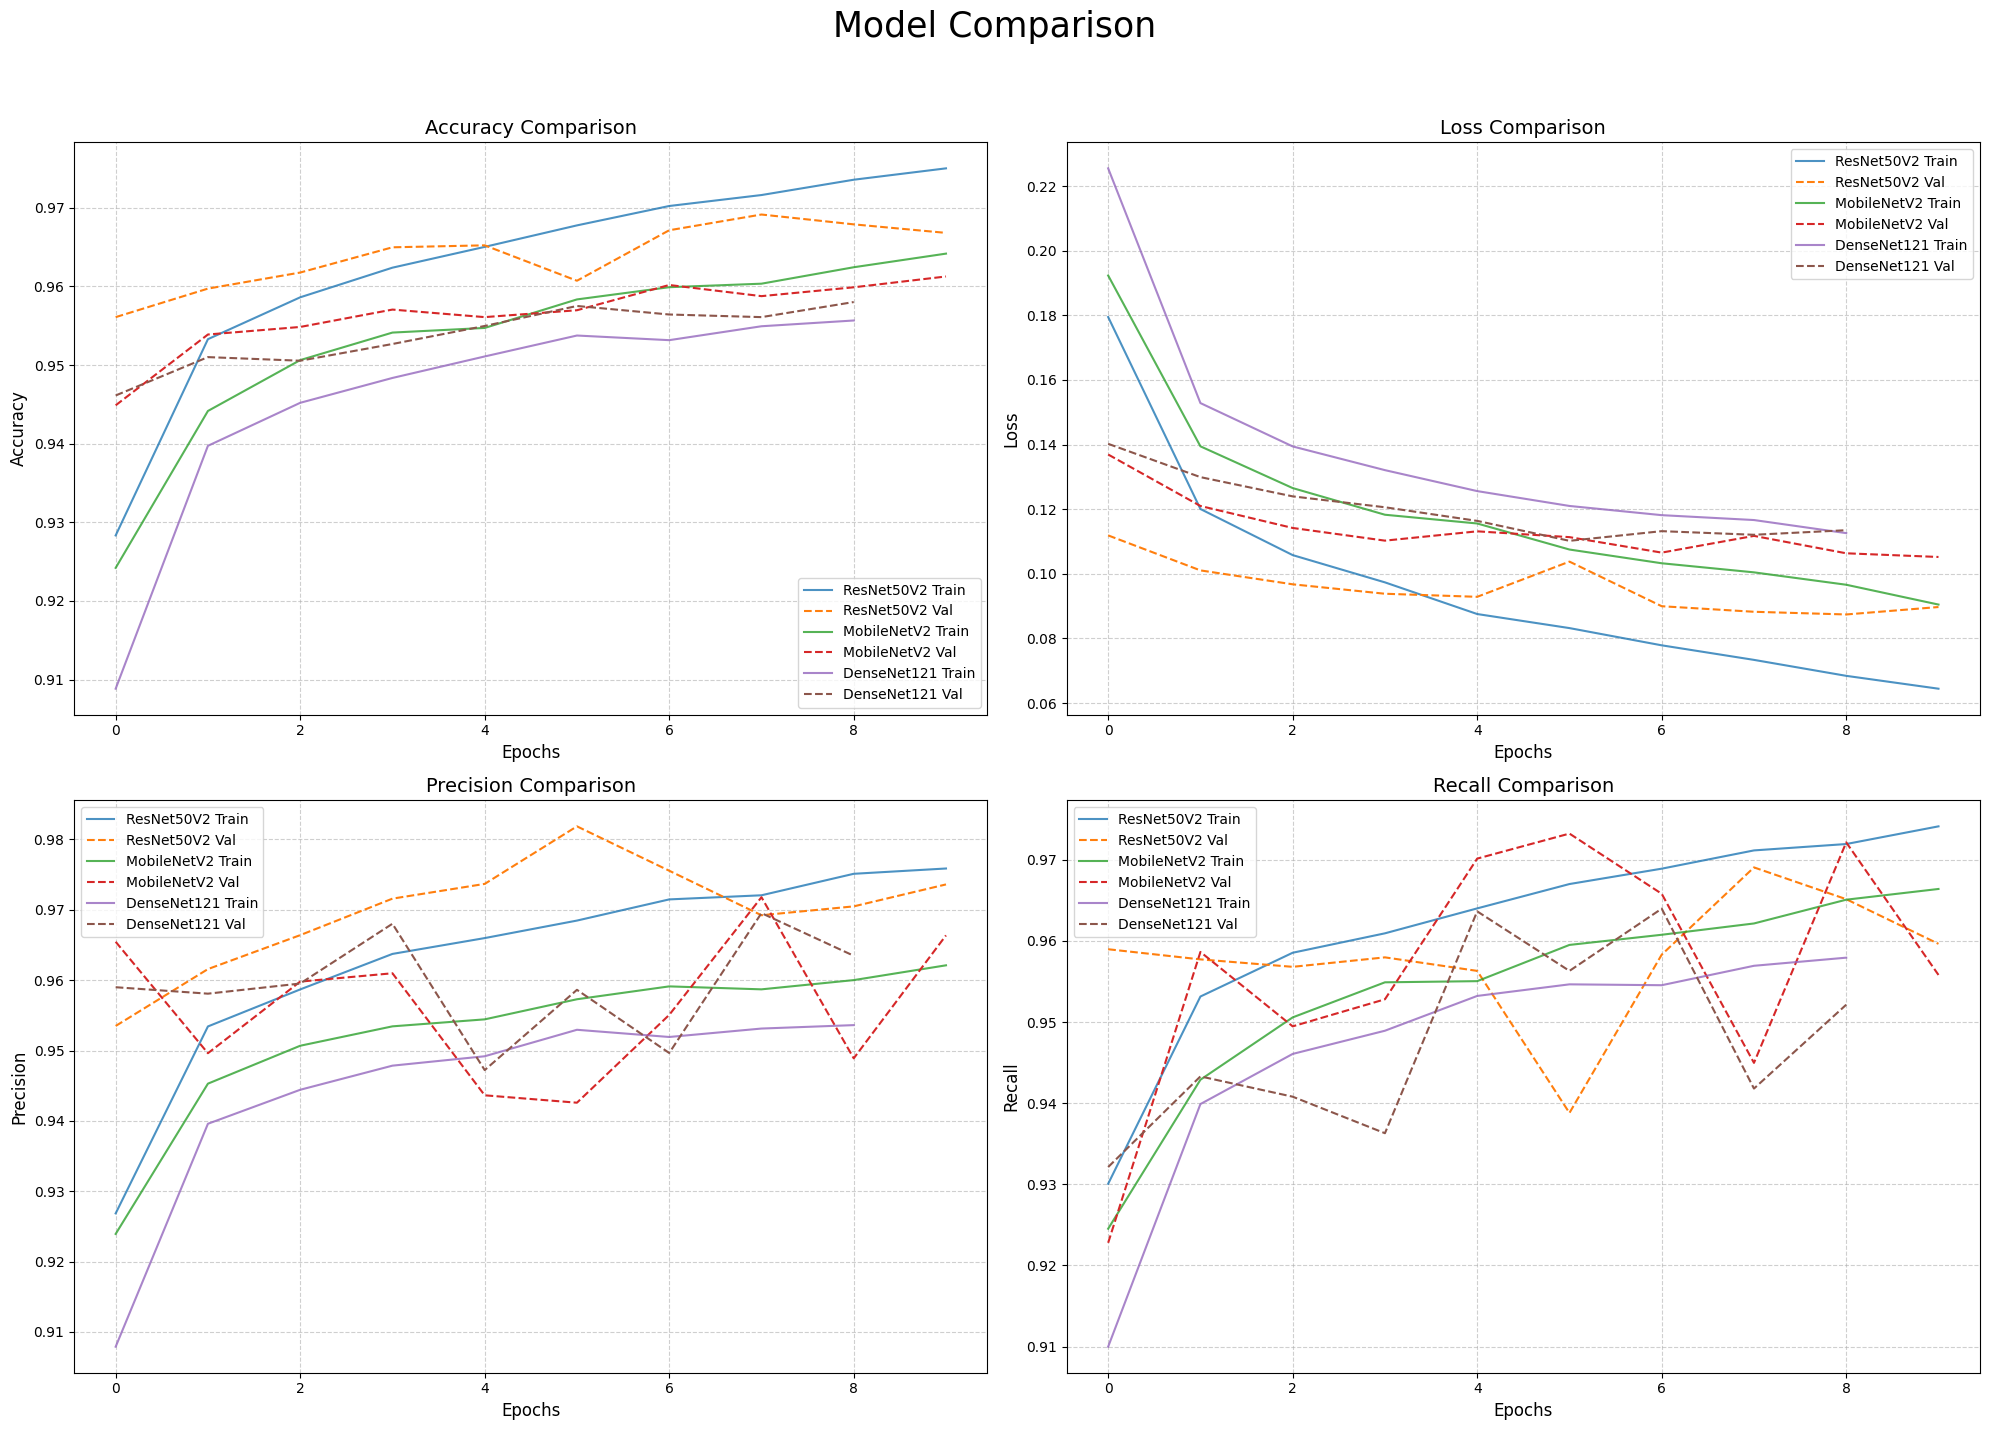

In [21]:
resnet_log_path = 'ResNet50V2-AIvsHumanGenImages-Logs.csv'
mobilenet_log_path = 'MobileNetV2-AIvsHumanGenImages-Logs.csv'
# efficientnet_log_path = 'EfficientNetB2-AIvsHumanGenImages-Logs.csv'
densenet_log_path = 'DenseNet121-AIvsHumanGenImages-Logs.csv'

history_files = {
    "ResNet50V2": resnet_log_path,
    "MobileNetV2": mobilenet_log_path,
    # "EfficientNetB2": efficientnet_log_path,
    "DenseNet121": densenet_log_path
}

histories = {}
for model_name, path in history_files.items():
    if os.path.exists(path):
        histories[model_name] = pd.read_csv(path)
        print(f"Berhasil memuat log untuk {model_name}")
    else:
        print(f"Peringatan: File log tidak ditemukan di '{path}'. Model '{model_name}' akan dilewati.")

if not histories:
    print("Tidak ada file log history yang dapat dimuat. Grafik tidak dapat dibuat.")
else:
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Model Comparison', fontsize=25)

    metrics = {
        'Accuracy': ('accuracy', 'val_accuracy'),
        'Loss': ('loss', 'val_loss'),
        'Precision': ('precision', 'val_precision'),
        'Recall': ('recall', 'val_recall')
    }

    plot_coords = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for (metric_name, (train_metric, val_metric)), ax_coords in zip(metrics.items(), plot_coords):
        ax = axs[ax_coords]

        for model_name, history_df in histories.items():
            if train_metric in history_df and val_metric in history_df:
                ax.plot(history_df[train_metric], label=f'{model_name} Train', alpha=0.8)
                ax.plot(history_df[val_metric], label=f'{model_name} Val', linestyle='--')

        ax.set_title(f'{metric_name} Comparison', fontsize=14)
        ax.set_xlabel('Epochs', fontsize=12)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('model_comparison_plots.png')
    print("\nComparison plot has been save as 'model_comparison_plots.png'")

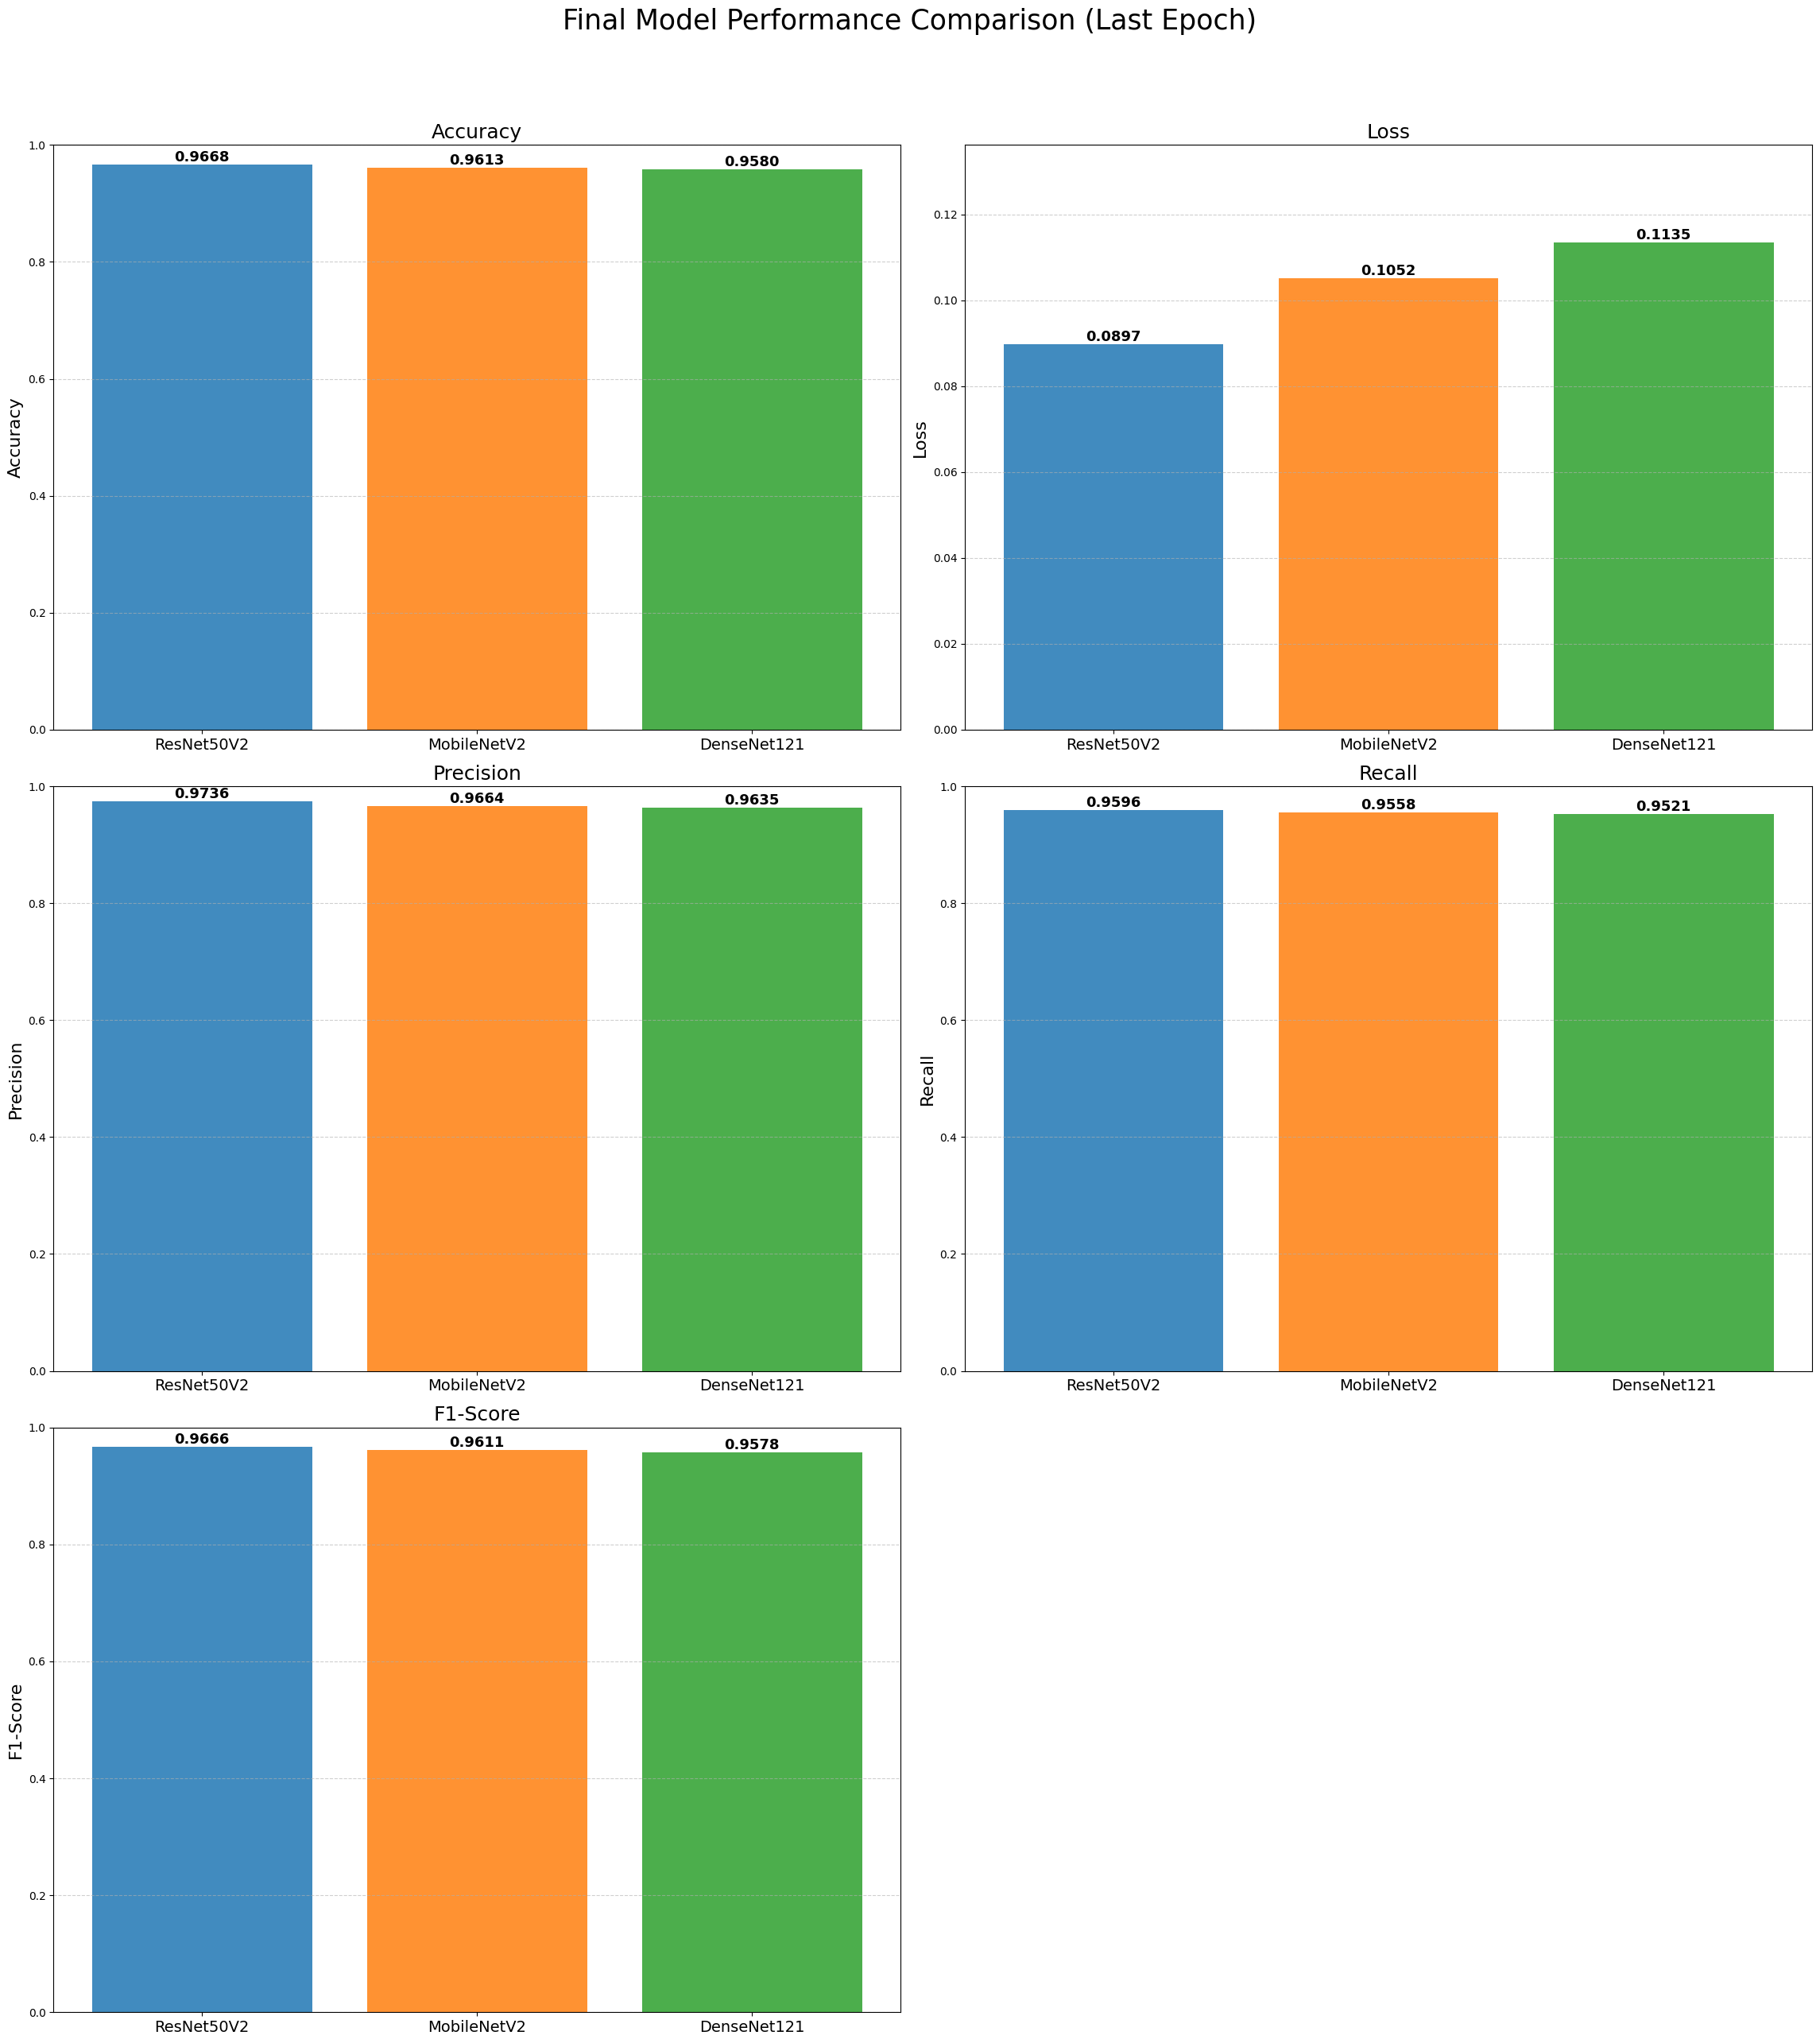

In [22]:
final_scores = {}

for model_name, history_df in histories.items():
    precision = history_df['val_precision'].iloc[-1]
    recall = history_df['val_recall'].iloc[-1]
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    final_scores[model_name] = {
        "Accuracy": history_df['val_accuracy'].iloc[-1],
        "Loss": history_df['val_loss'].iloc[-1],
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

metrics = ["Accuracy", "Loss", "Precision", "Recall", "F1-Score"]

colors = plt.cm.tab10.colors
model_names = list(final_scores.keys())
model_colors = {model: colors[i % len(colors)] for i, model in enumerate(model_names)}

fig, axs = plt.subplots(3, 2, figsize=(23, 27))
fig.suptitle('Final Model Performance Comparison (Last Epoch)', fontsize=25)

axs = axs.flatten()
plot_coords = range(len(metrics))

for metric, idx in zip(metrics, plot_coords):
    ax = axs[idx]
    values = [final_scores[m][metric] for m in final_scores]
    bars = ax.bar(model_names, values, color=[model_colors[m] for m in model_names], alpha=0.85)

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.4f}', ha='center', va='bottom', fontsize=13, fontweight='bold')

    ax.set_title(metric, fontsize=18)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', labelsize=14, labelrotation=0)
    ax.set_ylim(0, 1 if metric not in ["Loss"] else max(values) * 1.2)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

for j in range(len(metrics), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('model_comparison_barplots.png')
plt.show()